In [ ]:
import tensorflow as tf
import os

In [ ]:
input_dir = "/content/drive/MyDrive/FESB_MLID/train_images/src"
target_dir = "/content/drive/MyDrive/FESB_MLID/train_images/gt"

img_width = 256
img_height = 256
batch_size = 10

In [ ]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

In [ ]:
len(input_img_paths)

200

In [ ]:
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".bmp") and not fname.startswith(".")
    ]
)

In [ ]:
len(target_img_paths)

200

In [ ]:
for input_path, target_path in zip(input_img_paths, target_img_paths):
    print(input_path, "|", target_path)

/content/drive/MyDrive/FESB_MLID/train_images/src/src_1.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_1.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_100.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_100.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_102.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_102.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_103.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_103.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_104.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_104.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_108.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_108.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_11.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_11.bmp
/content/drive/MyDrive/FESB_MLID/train_images/src/src_114.jpg | /content/drive/MyDrive/FESB_MLID/train_images/gt/gt_114.bmp
/content/drive

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

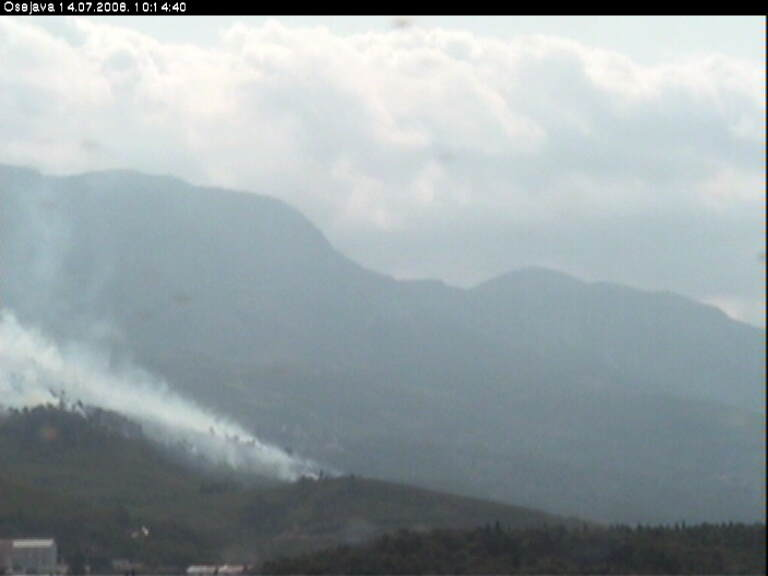

In [ ]:
display(Image(filename=input_img_paths[17]))

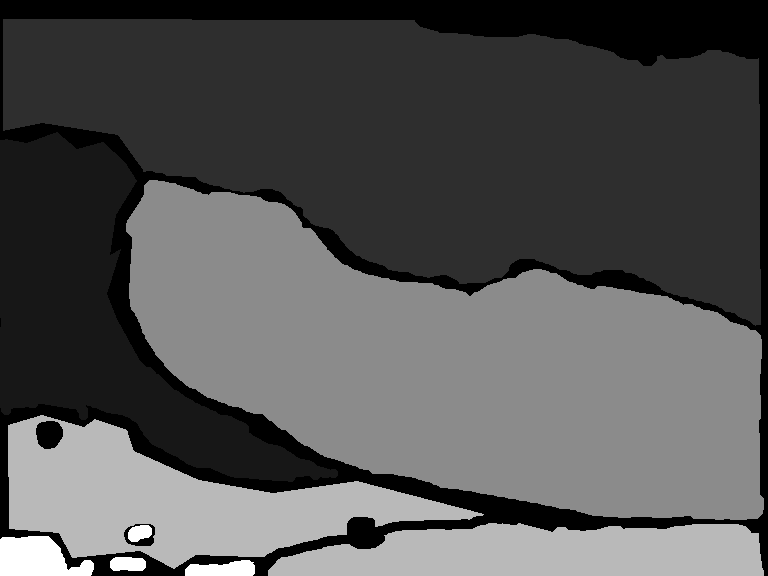

In [ ]:
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[17]))
display(img)

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
from skimage.transform import resize

In [ ]:
class FESB_MLID(keras.utils.Sequence):
    """ Helper to iterate over the data (as Numpy arrays). """

    def __init__(self, batch_size, img_width, img_height, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """ Returns tuple (input, target) correspond to batch #idx. """

        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size, img_height, img_width, 3), dtype=np.float32)
        for image_index, path in enumerate(batch_input_img_paths):
            img = load_img(path)
            x_img = img_to_array(img)
            x_img = resize(x_img, (img_height, img_width, 3), mode='constant')
            x[image_index] = x_img

        y = np.zeros((self.batch_size, img_height, img_width, 3), dtype=np.float32)
        for target_index, path in enumerate(batch_target_img_paths):
            target_img = img_to_array(load_img(path))
            target_img = resize(target_img, (img_height, img_width, 3), mode='constant')
            y[target_index] = target_img / 255
        
        return x, y


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import random

val_samples = 20
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = FESB_MLID(
    batch_size, img_width, img_height, train_input_img_paths, train_target_img_paths
)
val_gen = FESB_MLID(
    batch_size, img_width, img_height, val_input_img_paths, val_target_img_paths)

In [ ]:
type(train_gen)

__main__.FESB_MLID

In [ ]:
type(train_gen[0])

tuple

In [ ]:
type(train_gen[0][0])

numpy.ndarray

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [ ]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((img_height, img_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(train_gen, batch_size=batch_size, epochs=10, callbacks=callbacks,
                    validation_data=(val_gen))

Epoch 1/10
18/18 [==============================] - 199s 11s/step - loss: 0.7877 - accuracy: 0.0710 - val_loss: 6.4970 - val_accuracy: 0.1606

Epoch 00001: val_loss improved from inf to 6.49704, saving model to model-tgs-salt.h5
Epoch 2/10
18/18 [==============================] - 148s 8s/step - loss: 0.6558 - accuracy: 0.1163 - val_loss: 2.9180 - val_accuracy: 0.2665

Epoch 00002: val_loss improved from 6.49704 to 2.91803, saving model to model-tgs-salt.h5
Epoch 3/10
18/18 [==============================] - 147s 8s/step - loss: 0.6407 - accuracy: 0.1570 - val_loss: 1.0007 - val_accuracy: 0.2292

Epoch 00003: val_loss improved from 2.91803 to 1.00069, saving model to model-tgs-salt.h5
Epoch 4/10
18/18 [==============================] - 147s 8s/step - loss: 0.6248 - accuracy: 0.1675 - val_loss: 0.7061 - val_accuracy: 0.2105

Epoch 00004: val_loss improved from 1.00069 to 0.70610, saving model to model-tgs-salt.h5
Epoch 5/10
18/18 [==============================] - 151s 8s/step - loss: 0.

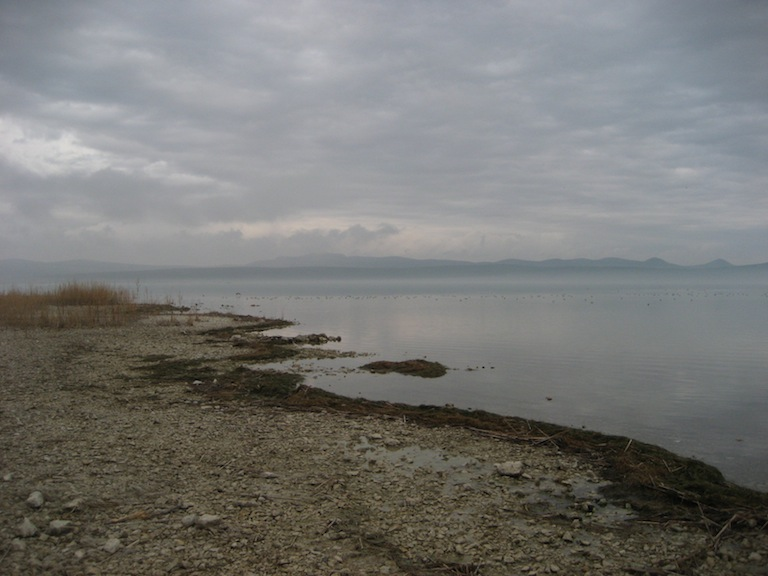

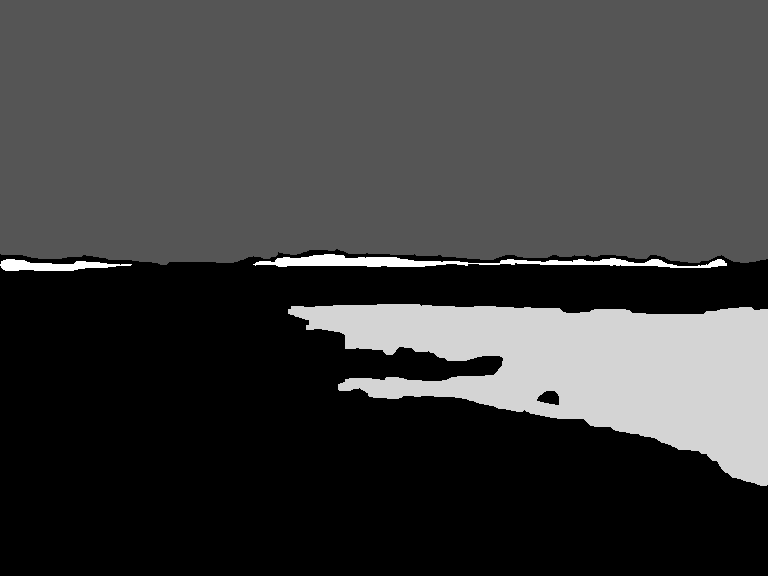

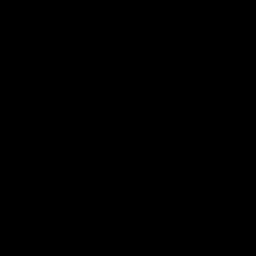

In [ ]:
val_gen = FESB_MLID(
    batch_size, img_width, img_height, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

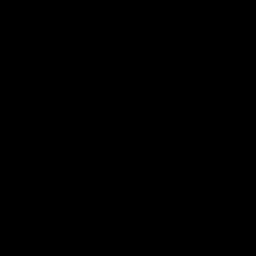

In [ ]:
display_mask(i)  # Note that the model only sees inputs at 150x150.